# **Common Prosperity Simulation**
## Computational Physics Lab 
Authors: Yuan-Yen Peng, Chih-Tian Ho  
E-mail: garyphys0915@gapp.nthu.edu.tw, chihtian.ho@gapp.nthu.edu.tw  
Dept of Physics, NTHU, Taiwan   
Date: Jan. 09, 2023  
Version: 5.1.0      
License: MIT

In [281]:
%reset -f
problem_name = 'Common_Prosperity'

In [282]:
import os, sys, stat
import shutil
from pathlib import Path

if os.path.exists(Path(f'./fig_{problem_name}')) == True:
    os.chmod(f'./fig_{problem_name}', stat.S_IRWXU)
    shutil.rmtree(f'./fig_{problem_name}')
    print('old folder has been removed!')

old folder has been removed!


In [283]:
import numpy as np
from scipy.misc import derivative
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numba import njit, prange
import time
from PIL import Image
import glob

### initial conditions

In [284]:
# setup
io_title = problem_name
io_freq = 4 # how many steps to record the data, unit [1 month]
# unit
month = 30 # [days]
yr = 12 * month # unit: days
# size
size = int(1e3)
width, length = size, size # grid's width and length
N = int(width * length) # how many sites
tmax =  0.1 * 3 * yr # [days]
n = int(tmax / 7) # time steps [days]

# initial energy conditions
J = 1 # configuration constant (positive means paramagnetism)

# initial bkg condition, set the standard diviation for x & y are both 3 
SsizeE = 0.1
sigma_x, sigma_y = SsizeE * width, SsizeE * length

# intial self condition, set eta, will be adjust by results (absorbing coeff)
eta = 0.07 # absorbing rate constant

# subsidy constant for equality and justice case respectively
# quarter (Q1, Q2, Q3, Q4) --> 3 * 4 weeks
s_time = 3 * 4 * 7
se = int(10/10) * 0.01
sj = int(10/2) * se

# probability
p = 0.01 # rich --> poor
q = 0.01 # poor --> rich

### Grid generator

In [285]:
def grid_generator(width, length, init_rank:float = 3.0, dec: int = 2):
  '''
  This is a grid generator
  :para width: width of the grid
  :para length: lerngth of the grid
  :para init_rank: bounds of initial rank of the grid; i.e., if use 3, --> [-3, 3]
  :para dec: decimal for the function <round>
  '''

  grid_positive = np.round(init_rank * np.random.random(int(N/2)), dec)
  grid_negative = np.round(-init_rank * np.random.random(int(N/2)), dec)
  grid = np.append(grid_positive, grid_negative)
  np.random.shuffle(grid) # set it to random
  grid = grid.reshape((width, length))

  # add the boundaries to four margins with minimum initial rank - 1
  tor = - (init_rank + 1)
  res = np.array([tor * np.ones(length)])
  grid_boundary = np.concatenate((res, grid, res), axis=0)
  grid_boundary = np.insert(grid_boundary, (0, length), tor, axis=1)

  return grid, grid_boundary

In [286]:
def plot(arr, header, lim, size = 8, dpi = 80):
  '''
  :para arr: input data: 2D Array
  '''

  figure(figsize=(size, size), dpi=dpi)
  plt.imshow(arr, cmap='coolwarm', extent=[-width/2,width/2,-length/2,length/2], alpha=.85)
  plt.colorbar()
  plt.clim(-lim-2.5, lim+2.5)
  plt.title(f'{header}')

  return

In [287]:
def plot_ct(arr, header, lim, size = 8, dpi = 80):
  '''
  :para arr: input data: 2D Array
  '''

  figure(figsize=(size, size), dpi=dpi)
  plt.imshow(arr, cmap='coolwarm', extent=[-width/2,width/2,-length/2,length/2], alpha=.75)
  plt.colorbar()
  # plt.contour(arr, colors='w', extent=[-width/2,width/2,-length/2,length/2], alpha=.85)
  plt.clim(-lim-1, lim+1)
  plt.title(f'{header}')

  return

### output

make the directories

In [288]:
io_folder_fig = "fig_" + io_title
Path(io_folder_fig).mkdir(parents=True, exist_ok=True)

output figures

In [289]:
def output_fig(n, arr, lim, time, title):
  """
  Write simulation data into a file named "fig"
  """
  header = f"{title}, time = {int(time)}"
  plot(arr, header, lim)
  fig = f'{io_folder_fig}/fig_{io_title}_{title}_{str(n).zfill(3)}.png'
  plt.savefig(fig)
  plt.close() # in order to save memory

  return 

### main exchange functions

#### Energy (each time)

In [290]:
@njit(parallel = True) # faster than jit if using "parallel"
def energy(spin, N, J, h):
  '''
  :para spin: is a spin matrix
  :para N: is the total number of sites
  :para J: is configuration constant (positive means paramagnetism)
  :para h: is external field
  '''

  l = int(np.sqrt(N))
  energy = np.zeros((l+2, l+2))
  for i in prange(1, l+1):
    for j in prange(1, l+1):
      s_cen  = spin[i  , j  ]
      s_up   = spin[i-1, j  ]
      s_rig  = spin[i  , j+1]
      s_down = spin[i+1, j  ]
      s_lef  = spin[i  , j-1]

      energy[i, j] = -J * s_up * s_rig * s_down * s_lef - h * s_cen

  return energy

#### Magnetization (each time)

In [291]:
def mag(spin):
  '''
  :para m: magnetization per spin (site)
  :para M: total magnetization
  '''

  M = np.sum(spin)
  m = np.average(spin)
  return m, M

#### Susceptibility

In [292]:
# @njit(parallel = True)
def X(f, h, x, size):
    dx = 1e-3
    for i in range(size):
        x[i] = derivative(f, h[i], dx)
    return x

#### Background function (each time)

In [293]:
@njit(parallel = True)
def bkg(N, sigma_x, sigma_y):
  '''
  :para N: is the total number of sites
  :para sigma_x: is a standard deviation in x-direction
  :para sigma_y: is a standard deviation in y-direction
  '''

  # l is the length; l_incluse is the length with margins; i.e., +2
  l = int(np.sqrt(N))
  l_include = l + 2
  coeff = 8e3
  BKG = np.ones((l_include, l_include))
  sigma = np.sqrt(np.square(sigma_x) + np.square(sigma_y))
  for i in prange(l):
        for j in prange(l):
            r = np.sqrt(np.square(i - l_include/2 + 2) + np.square(j - l_include/2 + 2))
            BKG[i, j] = coeff * (1/(np.sqrt(2 * np.pi) * sigma)) * (np.exp(-np.square(r) / (2 * np.square(sigma))))
  return BKG

#### Fitting

In [294]:
def func_exp(x, a, b, c, d):
  return -a * np.exp(-b * x + c) + d

def func_repo(x, a, b, c, d):
  return -a / (b*x + c) + d

In [295]:
def f(x, popt):
   return -popt[0] * np.exp(-popt[1] * x + popt[2]) + popt[3]

In [296]:
def CS(x, y):
  # cs = CubicSpline(x, y)
  cs = InterpolatedUnivariateSpline(x, y)
  der = UnivariateSpline(x, y).derivatives(x)
  return cs, der

#### Self (spin) function (each time)

In [297]:
@njit(parallel = True)
def self(N, t, tmax, spin, bkg, eta):
    '''
        :para N: is the total number of sites
        :para t: is the time in the moment
        :para spin: is the spin matrix
        :para bkg: is the background function
        :para eta: absorbing rate constant

        1) set another array called new playground as nspin to save the new Hierarchy, 
            and update when all units are calculated.
        2) note that no need for bkg since they are indep. for each
    '''
    l = int(np.sqrt(N))
    nspin = np.copy(spin) # this is temp of spin (which depend on spin)
    for i in prange(1, l+1):
        for j in prange(1, l+1):

            # setup relative spins positions
            s_cen  = spin[i  , j  ]
            s_up   = spin[i-1, j  ]
            s_rig  = spin[i  , j+1]
            s_down = spin[i+1, j  ]
            s_lef  = spin[i  , j-1]

            # temp spin matrix
            nspin[i,j] += (0.5 / (3 * np.sqrt(2*np.pi)) * np.exp(-(np.square(s_cen)/(2 * np.square(3)))) * (-(4*s_cen - s_rig -s_lef - s_up - s_down))
                            + 0.5 * eta * (0.05 * np.exp(-5) * np.exp(s_cen)
                                            + (0.95 / (3 * np.sqrt(2 * np.pi))) * np.exp(-np.square(s_cen)/(2 * np.square(3)))) * bkg[i,j] * np.sin(2 * np.pi * t/tmax))
                            
            # rich --> poor
            if nspin[i,j] >= 5 and (s_rig + s_lef + s_up + s_down)/4 > 4:
                    # C are the random number [0, 1]
                    C = np.random.randint(100) / 100
                    if C <= p:
                        # the ``cross region'' will also be implicated.
                        nspin[i+1, j  ] = 0.3 * nspin[i+1, j  ] 
                        nspin[i  , j+1] = 0.3 * nspin[i  , j+1]
                        nspin[i  , j  ] = -4
                        nspin[i-1, j  ] = 0.3 * nspin[i-1, j  ]
                        nspin[i  , j-1] = 0.3 * nspin[i  , j-1]
                    else:
                        nspin[i, j] = 5
            elif nspin[i,j] >= 5 and (s_rig + s_lef + s_up + s_down)/4 <= 4:
                        nspin[i, j] = 5

            # poor --> rich
            elif nspin[i,j] <= -5 and (s_rig + s_lef + s_up + s_down)/4 < -4:
                    # C are the random number [0, 1]
                    C = np.random.randint(100) / 100
                    if C <= q:
                        nspin[i+1, j  ] = 0.3 * nspin[i+1, j  ] 
                        nspin[i  , j+1] = 0.3 * nspin[i  , j+1]
                        nspin[i  , j  ] = 4
                        nspin[i-1, j  ] = 0.3 * nspin[i-1, j  ]
                        nspin[i  , j-1] = 0.3 * nspin[i  , j-1]
                    else:
                        nspin[i, j] = -5    
            elif nspin[i,j] <= -5 and (s_rig + s_lef + s_up + s_down)/4 >= -4:
                        nspin[i, j] = -5
            # site max and min is +5 and -5

            '''
            bkg is only decay with the time (add the constraint of cos finction with the period t_max)
            '''      

            bkg[i,j] -= eta * (0.05 * np.exp(-5) * np.exp(s_cen) 
                                + (0.95 / (3 * np.sqrt(2 * np.pi))) * np.exp(-np.square(s_cen)/(2 * np.square(3)))) * bkg[i,j] * np.sin(2 * np.pi * t/tmax)

    spin = np.copy(nspin) # temp of spin = new spin (the next next matrix)

    return spin, bkg

#### Equality (self)

In [298]:
@njit(parallel = True)
def self_eq(N, t, tmax, spin, bkg, eta, se, s_time):
  '''
    :para N: is the total number of sites
    :para t: is the time in the moment
    :para spin: is the spin matrix
    :para bkg: is the background function
    :para eta: absorbing rate constant

    1) set another array called new playground as nspin to save the new Hierarchy, 
        and update when all units are calculated.
    2) note that no need for bkg since they are indep. for each
  '''
  l = int(np.sqrt(N))
  nspin = np.copy(spin) # this is temp of spin (which depend on spin)
  for i in prange(1, l+1):
      for j in prange(1, l+1):

          # setup relative spins positions
          s_cen  = spin[i  , j  ]
          s_up   = spin[i-1, j  ]
          s_rig  = spin[i  , j+1]
          s_down = spin[i+1, j  ]
          s_lef  = spin[i  , j-1]

          # temp spin matrix
          nspin[i,j] += (0.5 / (3 * np.sqrt(2*np.pi)) * np.exp(-(np.square(s_cen)/(2 * np.square(3)))) * (-(4*s_cen - s_rig -s_lef - s_up - s_down))
                                      + 0.5 * eta * (0.05 * np.exp(-5) * np.exp(s_cen)
                                              + (0.95/(3 * np.sqrt(2 * np.pi))) * np.exp(-np.square(s_cen)/(2 * np.square(3)))) * bkg[i,j] * np.sin(2 * np.pi * t/tmax))

          # Equality (all sites in mid-class [-3,3] will add se)
          # add another subsidy constant "se"
          if int(t) % s_time == 0:
            nspin[i,j] += se
            # print(f"t = {int(t)}, subsidize!")
            
          # rich --> poor
          if nspin[i,j] >= 5 and (s_rig + s_lef + s_up + s_down)/4 > 4:
                # C are the random number [0, 1]
                C = np.random.randint(100) / 100
                if C <= p:
                    # the ``cross region'' will also be implicated.
                    nspin[i+1, j  ] = 0.3 * nspin[i+1, j  ] 
                    nspin[i  , j+1] = 0.3 * nspin[i  , j+1]
                    nspin[i  , j  ] = -4
                    nspin[i-1, j  ] = 0.3 * nspin[i-1, j  ]
                    nspin[i  , j-1] = 0.3 * nspin[i  , j-1]
                else:
                    nspin[i, j] = 5
          elif nspin[i,j] >= 5 and (s_rig + s_lef + s_up + s_down)/4 <= 4:
                    nspin[i, j] = 5

          # poor --> rich
          elif nspin[i,j] <= -5 and (s_rig + s_lef + s_up + s_down)/4 < -4:
                # C are the random number [0, 1]
                C = np.random.randint(100) / 100
                if C <= q:
                        nspin[i+1, j  ] = 0.3 * nspin[i+1, j  ] 
                        nspin[i  , j+1] = 0.3 * nspin[i  , j+1]
                        nspin[i  , j  ] = 4
                        nspin[i-1, j  ] = 0.3 * nspin[i-1, j  ]
                        nspin[i  , j-1] = 0.3 * nspin[i  , j-1]
                else:
                    nspin[i, j] = -5    
          elif nspin[i,j] <= -5 and (s_rig + s_lef + s_up + s_down)/4 >= -4:
                    nspin[i, j] = -5
          # site max and min is +5 and -5

          '''
          bkg is only decay with the time (add the constraint of cos finction with the period t_max)
          '''      

          bkg[i,j] -= eta * (0.05 * np.exp(-5) * np.exp(s_cen) 
                              + (0.95 / (3 * np.sqrt(2 * np.pi))) * np.exp(-np.square(s_cen)/(2 * np.square(3)))) * bkg[i,j] * np.sin(2 * np.pi * t/tmax)

  spin = np.copy(nspin) # temp of spin = new spin (the next next matrix)

  return spin, bkg

#### Justice (self)

In [299]:
@njit(parallel = True)
def self_ju(N, t, tmax, spin, bkg, eta, sj, s_time):
  '''
    :para N: is the total number of sites
    :para t: is the time in the moment
    :para spin: is the spin matrix
    :para bkg: is the background function
    :para eta: absorbing rate constant

    1) set another array called new playground as nspin to save the new Hierarchy, 
        and update when all units are calculated.
    2) note that no need for bkg since they are indep. for each
  '''
  l = int(np.sqrt(N))
  nspin = np.copy(spin) # this is temp of spin (which depend on spin)
  for i in prange(1, l+1):
      for j in prange(1, l+1):

          # setup relative spins positions
          s_cen  = spin[i  , j  ]
          s_up   = spin[i-1, j  ]
          s_rig  = spin[i  , j+1]
          s_down = spin[i+1, j  ]
          s_lef  = spin[i  , j-1]

          # temp spin matrix
          nspin[i,j] += (0.5 / (3 * np.sqrt(2*np.pi)) * np.exp(-(np.square(s_cen)/(2 * np.square(3)))) * (-(4*s_cen - s_rig -s_lef - s_up - s_down))
                                      + 0.5 * eta * (0.05 * np.exp(-5) * np.exp(s_cen)
                                              + (0.95/(3 * np.sqrt(2 * np.pi))) * np.exp(-np.square(s_cen)/(2 * np.square(3)))) * bkg[i,j] * np.sin(2 * np.pi * t/tmax))

          # Justice (only the sites in low-class [-3,0) will add sj)
          # add another subsidy constant "sj"
          # middle class store subsidy
          if int(t) % s_time == 0:
            if nspin[i,j] < 0 and nspin[i,j] >= -5:
              nspin[i,j] += sj
              
              # if s_time == s_time:
              #   print(f"t = {int(t)}, subsidize!")
              #   break
              
          # rich --> poor
          if nspin[i,j] >= 5 and (s_rig + s_lef + s_up + s_down)/4 > 4:
                # C are the random number [0, 1]
                C = np.random.randint(100) / 100
                if C <= p:
                    # the ``cross region'' will also be implicated.
                    nspin[i+1, j  ] = 0.3 * nspin[i+1, j  ] 
                    nspin[i  , j+1] = 0.3 * nspin[i  , j+1]
                    nspin[i  , j  ] = -4
                    nspin[i-1, j  ] = 0.3 * nspin[i-1, j  ]
                    nspin[i  , j-1] = 0.3 * nspin[i  , j-1]
                else:
                    nspin[i, j] = 5
          elif nspin[i,j] >= 5 and (s_rig + s_lef + s_up + s_down)/4 <= 4:
                    nspin[i, j] = 5

          # poor --> rich
          elif nspin[i,j] <= -5 and (s_rig + s_lef + s_up + s_down)/4 < -4:
                # C are the random number [0, 1]
                C = np.random.randint(100) / 100
                if C <= q:
                        nspin[i+1, j  ] = 0.3 * nspin[i+1, j  ] 
                        nspin[i  , j+1] = 0.3 * nspin[i  , j+1]
                        nspin[i  , j  ] = 4
                        nspin[i-1, j  ] = 0.3 * nspin[i-1, j  ]
                        nspin[i  , j-1] = 0.3 * nspin[i  , j-1]
                else:
                    nspin[i, j] = -5    
          elif nspin[i,j] <= -5 and (s_rig + s_lef + s_up + s_down)/4 >= -4:
                    nspin[i, j] = -5
          # site max and min is +5 and -5

          '''
          bkg is only decay with the time (add the constraint of cos finction with the period t_max)
          '''

          bkg[i,j] -= eta * (0.05 * np.exp(-5) * np.exp(s_cen) 
                              + (0.95 / (3 * np.sqrt(2 * np.pi))) * np.exp(-np.square(s_cen)/(2 * np.square(3)))) * bkg[i,j] * np.sin(2 * np.pi * t/tmax)

  spin = np.copy(nspin) # temp of spin = new spin (the next next matrix)

  return spin, bkg

### Main loop

In [300]:
# main (loop of time)
def main(N, n, tmax, spin, J, sigma_x, sigma_y, eta, *args):
    '''
    This is the main loop function, and it will also output the figures(.png).

    :para N: is the total number of sites
    :para n: is total number of time steps
    :para T: is the total time
    :para spin: is the spin matrix
    :para J: is configuration constant (positive means paramagnetism)
    :para sigma_x: is a standard deviation in x-direction
    :para sigma_y: is a standard deviation in y-direction
    :para eta: absorbing rate constant
    '''

    dt = 7
    t = 0
    temp_n = 0
    
    # initial setup checking 
    bk = bkg(N, sigma_x, sigma_y)
    h = 0.2 * np.average(bk) # set no bkg influences in the beginning
    Ei =energy(spin, N, J, h)
    Ei = np.delete(Ei, (0, -1), 0)
    Ei = np.delete(Ei, (0, -1), 1)
    Si = np.delete(spin, (0, -1), 0)
    Si = np.delete(Si, (0, -1), 1)
    
    m      = np.array([mag(Si)[0]])
    M      = np.array([mag(Si)[1]])
    H      = np.array([h])
    Energy = np.array([np.average(Ei)])
    
    # initial output
    clim_spin = np.max(np.abs(Si))
    clim_energy = np.max(np.abs(Ei))
    output_fig(temp_n, Si, clim_spin, t, "norm_spin")
    output_fig(temp_n, Ei, clim_energy, t, "norm_energy")
    print("Initial t = 0, succeed to output!")

    t1 = time.time()
    while t < tmax:
      # update data
      epsilon =energy(spin, N, J, h)
      spin = self(N, t, tmax, spin, bk, eta)[0]
      h = 0.2 * np.average(self(N, t, tmax, spin, bk, eta)[1])
      
      # prune margins
      S = np.delete(spin, (0, -1), 0)
      S = np.delete(S, (0, -1), 1)
      E = np.delete(epsilon, (0, -1), 0)
      E = np.delete(E, (0, -1), 1)
      
      m      = np.append(m, mag(S)[0])
      M      = np.append(M, mag(S)[1])
      H      = np.append(H, h)
      Energy = np.append(Energy, np.average(E))

      # output files
      if (temp_n % io_freq == 0):
        '''
        output info files

        '''
        output_fig(temp_n+1, S, clim_spin, t+dt, "norm_spin")
        output_fig(temp_n+1, E, clim_energy, t+dt, "norm_energy")
        print(f"{temp_n}, t = {np.round(t+dt, 2)}, succeed to output!")

      # update time and steps
      temp_n += 1
      t += dt
      if t + dt > tmax:
        dt = tmax - t

        # plot the last figure with "contour"
        # plot_ct(S, f"spin, t = {np.round(t, 2)}", clim_spin, size = 8, dpi = 80)
        # plot_ct(E, f"energy, t = {np.round(t, 2)}", clim_energy, size = 8, dpi = 80)
    t2 = time.time()
    
    # output
    T = np.linspace(0, tmax, temp_n+1)
    
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('time [code unit]')
    plt.ylabel('m [code unit]')
    plt.title(f'Magnetization per spin with {size}, (normal)')
    plt.plot(T, m, '--.', alpha = .6)
    plt.grid(True)
    plt.show()
    
    # figure(figsize=(9, 6), dpi=80)
    # plt.xlabel('time [code unit]')
    # plt.ylabel('M [code unit]')
    # plt.title(f'Magnetization with {size}')
    # plt.plot(T, M, '--.', alpha = .6)
    # plt.grid(True)
    # plt.show()
    
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('time [code unit]')
    plt.ylabel('Energy [code unit]')
    plt.title(f'Average Energy vs Time, (normal)')
    plt.plot(T, Energy, '--.', alpha = .6)
    plt.grid(True)
    plt.show()
    
    HH = np.sort(H, axis=None)
    mm = np.sort(m, axis=None)

    xdata = HH
    ydata = mm
    
    # fitting m-h
    popt, pcov = curve_fit(func_exp, xdata, ydata, bounds=(-0.5, [2., 50., 2., 1.]))
    popt_, pcov_ = curve_fit(func_repo, xdata, ydata, bounds=(0.5, [2., 10., 2., 1.]), p0=([2,5,1,0.6])) 
    cubic = CS(xdata, ydata)
    
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('h [code unit]')
    plt.ylabel('m [code unit]')
    plt.title(f'Magnetization per spin vs outer field, (normal)')
    plt.plot(xdata, cubic[0],'--c', alpha = .5, label = f'Cubic Spline')
    plt.plot(xdata, func_exp(xdata, *popt), '--g', alpha = .5, label = f'exp fit with \n popt = {np.round(popt, 2)}')
    plt.plot(xdata, func_exp(xdata, *popt_), '--b', alpha = .5, label = f'reciprocal fit with \n popt = {np.round(popt_,2)}')
    plt.plot(HH, mm, '--.', color = 'coral', alpha = .3, label='data')
    plt.legend()
    plt.grid(True)
    plt.show()

    x = np.zeros(np.size(mm)-1)
    x_size = int(np.size(x))
    def f(x):
      return -popt[0] * np.exp(-popt[1] * x + popt[2]) + popt[3]
    xx = X(f, ydata, x, x_size)
    HH = np.delete(HH, [-1], axis=0)
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('h [code unit]')
    plt.ylabel('X [code unit]')
    plt.title(f'Susceptibility vs outer field, (normal)')
    plt.plot(xdata, cubic[1],'--.c', alpha = .5, label = f'Cubic Spline')
    plt.plot(HH, xx, '--.b', alpha = .5, label = 'Curve fit (exp)')
    plt.grid(True)
    plt.show()
    
    return print("Done! Time = ", np.round(t2 - t1, 3), "[s]")

#### main equality

In [301]:
# main (loop of time)
def main_e(N, n, tmax, spin, J, sigma_x, sigma_y, eta, *args):
    '''
    This is the main loop function, and it will also output the figures(.png).

    :para N: is the total number of sites
    :para n: is total number of time steps
    :para T: is the total time
    :para spin: is the spin matrix
    :para J: is configuration constant (positive means paramagnetism)
    :para sigma_x: is a standard deviation in x-direction
    :para sigma_y: is a standard deviation in y-direction
    :para eta: absorbing rate constant
    '''

    dt = 7
    t = 0
    temp_n = 0
    
    # initial setup checking 
    bk = bkg(N, sigma_x, sigma_y)
    h = 0.2 * np.average(bk) # set no bkg influences in the beginning
    Ei =energy(spin, N, J, h)
    Ei = np.delete(Ei, (0, -1), 0)
    Ei = np.delete(Ei, (0, -1), 1)
    Si = np.delete(spin, (0, -1), 0)
    Si = np.delete(Si, (0, -1), 1)
    
    m      = np.array([mag(Si)[0]])
    M      = np.array([mag(Si)[1]])
    H      = np.array([h])
    Energy = np.array([np.average(Ei)])
    
    # initial output
    clim_spin = np.max(np.abs(Si))
    clim_energy = np.max(np.abs(Ei))
    output_fig(temp_n, Si, clim_spin, t, "eq_spin")
    output_fig(temp_n, Ei, clim_energy, t, "eq_energy")
    print("Initial t = 0, succeed to output!")

    t1 = time.time()
    while t < tmax:
      # update data
      epsilon =energy(spin, N, J, h)
      spin = self_eq(N, t, tmax, spin, bk, eta, se, s_time)[0]
      h = 0.2 * np.average(self_eq(N, t, tmax, spin, bk, eta, se, s_time)[1])
      
      # prune margins
      S = np.delete(spin, (0, -1), 0)
      S = np.delete(S, (0, -1), 1)
      E = np.delete(epsilon, (0, -1), 0)
      E = np.delete(E, (0, -1), 1)
      
      m      = np.append(m, mag(S)[0])
      M      = np.append(M, mag(S)[1])
      H      = np.append(H, h)
      Energy = np.append(Energy, np.average(E))

      # output files
      if (temp_n % io_freq == 0):
        '''
        output info files

        '''
        output_fig(temp_n+1, S, clim_spin, t+dt, "eq_spin")
        output_fig(temp_n+1, E, clim_energy, t+dt, "eq_energy")
        print(f"{temp_n}, t = {np.round(t+dt, 2)}, succeed to output!")

      # update time and steps
      temp_n += 1
      t += dt
      if t + dt > tmax:
        dt = tmax - t

        # plot the last figure with "contour"
        # plot_ct(S, f"spin, t = {np.round(t, 2)}", clim_spin, size = 8, dpi = 80)
        # plot_ct(E, f"energy, t = {np.round(t, 2)}", clim_energy, size = 8, dpi = 80)
    t2 = time.time()
    
    # output
    T = np.linspace(0, tmax, temp_n+1)
    
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('time [code unit]')
    plt.ylabel('m [code unit]')
    plt.title(f'Magnetization per spin with {size}, (Equality)')
    plt.plot(T, m, '--.', alpha = .6)
    plt.grid(True)
    plt.show()
    
    # figure(figsize=(9, 6), dpi=80)
    # plt.xlabel('time [code unit]')
    # plt.ylabel('M [code unit]')
    # plt.title(f'Magnetization with {size}')
    # plt.plot(T, M, '--.', alpha = .6)
    # plt.grid(True)
    # plt.show()
    
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('time [code unit]')
    plt.ylabel('Energy [code unit]')
    plt.title(f'Average Energy vs Time, (Equality)')
    plt.plot(T, Energy, '--.', alpha = .6)
    plt.grid(True)
    plt.show()
    
    HH = np.sort(H, axis=None)
    mm = np.sort(m, axis=None)

    # fitting m-h
    xdata, ydata = HH, mm
    
    # fitting m-h
    popt, pcov = curve_fit(func_exp, xdata, ydata, bounds=(-0.5, [2., 50., 2., 1.]))
    popt_, pcov_ = curve_fit(func_repo, xdata, ydata, bounds=(0.5, [2., 10., 1., 1.]), p0=([2,5,1,0.6])) 
    cubic = CS(xdata, ydata)

    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('h [code unit]')
    plt.ylabel('m [code unit]')
    plt.title(f'Magnetization per spin vs outer field, (Equality)')
    plt.plot(xdata, cubic[0],'--c', alpha = .5, label = f'Cubic Spline')
    plt.plot(xdata, func_exp(xdata, *popt), '--g', alpha = .5, label = f'exp fit with \n popt = {np.round(popt, 2)}')
    plt.plot(xdata, func_exp(xdata, *popt_), '--b', alpha = .5, label = f'reciprocal fit with \n popt = {np.round(popt_,2)}')
    plt.plot(HH, mm, '--.', color = 'coral', alpha = .3, label='data')
    plt.legend()
    plt.grid(True)
    plt.show()

    x = np.zeros(np.size(mm)-1)
    x_size = int(np.size(x))
    def f(x):
      return -popt[0] * np.exp(-popt[1] * x + popt[2]) + popt[3]
    xx = X(f, ydata, x, x_size)
    HH = np.delete(HH, [-1], axis=0)
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('h [code unit]')
    plt.ylabel('X [code unit]')
    plt.title(f'Susceptibility vs outer field, (Equality)')
    plt.plot(xdata, cubic[1],'--.c', alpha = .5, label = f'Cubic Spline')
    plt.plot(HH, xx, '--.b', alpha = .5, label = 'Curve fit (exp)')
    plt.grid(True)
    plt.show()
    
    return print("Done! Time = ", np.round(t2 - t1, 3), "[s]")

#### main justice

In [302]:
# main (loop of time)
def main_j(N, n, tmax, spin, J, sigma_x, sigma_y, eta, *args):
    '''
    This is the main loop function, and it will also output the figures(.png).

    :para N: is the total number of sites
    :para n: is total number of time steps
    :para T: is the total time
    :para spin: is the spin matrix
    :para J: is configuration constant (positive means paramagnetism)
    :para sigma_x: is a standard deviation in x-direction
    :para sigma_y: is a standard deviation in y-direction
    :para eta: absorbing rate constant
    '''

    dt = 7
    t = 0
    temp_n = 0
    
    # initial setup checking 
    bk = bkg(N, sigma_x, sigma_y)
    h = 0.2 * np.average(bk) # set no bkg influences in the beginning
    Ei =energy(spin, N, J, h)
    Ei = np.delete(Ei, (0, -1), 0)
    Ei = np.delete(Ei, (0, -1), 1)
    Si = np.delete(spin, (0, -1), 0)
    Si = np.delete(Si, (0, -1), 1)
    
    m      = np.array([mag(Si)[0]])
    M      = np.array([mag(Si)[1]])
    H      = np.array([h])
    Energy = np.array([np.average(Ei)])
    
    # initial output
    clim_spin = np.max(np.abs(Si))
    clim_energy = np.max(np.abs(Ei))
    output_fig(temp_n, Si, clim_spin, t, "ju_spin")
    output_fig(temp_n, Ei, clim_energy, t, "ju_energy")
    print("Initial t = 0, succeed to output!")

    t1 = time.time()
    while t < tmax:
      # update data
      epsilon =energy(spin, N, J, h)
      spin = self_ju(N, t, tmax, spin, bk, eta, sj, s_time)[0]
      h = 0.2 * np.average(self_eq(N, t, tmax, spin, bk, eta, sj, s_time)[1])
      
      # prune margins
      S = np.delete(spin, (0, -1), 0)
      S = np.delete(S, (0, -1), 1)
      E = np.delete(epsilon, (0, -1), 0)
      E = np.delete(E, (0, -1), 1)
      
      m      = np.append(m, mag(S)[0])
      M      = np.append(M, mag(S)[1])
      H      = np.append(H, h)
      Energy = np.append(Energy, np.average(E))

      # output files
      if (temp_n % io_freq == 0):
        '''
        output info files

        '''
        output_fig(temp_n+1, S, clim_spin, t+dt, "ju_spin")
        output_fig(temp_n+1, E, clim_energy, t+dt, "ju_energy")
        print(f"{temp_n}, t = {np.round(t+dt, 2)}, succeed to output!")

      # update time and steps
      temp_n += 1
      t += dt
      if t + dt > tmax:
        dt = tmax - t

        # plot the last figure with "contour"
        # plot_ct(S, f"spin, t = {np.round(t, 2)}", clim_spin, size = 8, dpi = 80)
        # plot_ct(E, f"energy, t = {np.round(t, 2)}", clim_energy, size = 8, dpi = 80)
    t2 = time.time()
    
    # output
    T = np.linspace(0, tmax, temp_n+1)
    
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('time [code unit]')
    plt.ylabel('m [code unit]')
    plt.title(f'Magnetization per spin with {size}, (Justice)')
    plt.plot(T, m, '--.', alpha = .6)
    plt.grid(True)
    plt.show()
    
    # figure(figsize=(9, 6), dpi=80)
    # plt.xlabel('time [code unit]')
    # plt.ylabel('M [code unit]')
    # plt.title(f'Magnetization with {size}')
    # plt.plot(T, M, '--.', alpha = .6)
    # plt.grid(True)
    # plt.show()
    
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('time [code unit]')
    plt.ylabel('Energy [code unit]')
    plt.title(f'Average Energy vs Time, (Justice)')
    plt.plot(T, Energy, '--.', alpha = .6)
    plt.grid(True)
    plt.show()
    
    HH = np.sort(H, axis=None).flatten()
    mm = np.sort(m, axis=None).flatten()

    # fitting m-h
    xdata, ydata = HH, mm
    cubic = CS(xdata, ydata)
    
    popt, pcov = curve_fit(func_exp, xdata, ydata, bounds=(-0.5, [2., 50., 2., 1.]))
    popt_, pcov_ = curve_fit(func_repo, xdata, ydata, bounds=(0.5, [2., 10., 2., 1.]), p0=([2,5,1,0.6])) 

    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('h [code unit]')
    plt.ylabel('m [code unit]')
    plt.title(f'Magnetization per spin vs outer field, (Justice)')
    plt.plot(xdata, cubic[0],'--c', alpha = .5, label = f'Cubic Spline')
    plt.plot(xdata, func_exp(xdata, *popt), '--g', alpha = .5, label = f'exp fit with \n popt = {np.round(popt, 2)}')
    plt.plot(xdata, func_exp(xdata, *popt_), '--b', alpha = .5, label = f'reciprocal fit with \n popt = {np.round(popt_,2)}')
    plt.plot(HH, mm, '--.', color = 'coral', alpha = .3, label='data')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    x = np.zeros(np.size(mm)-1)
    x_size = int(np.size(x))
    def f(x):
      return -popt[0] * np.exp(-popt[1] * x + popt[2]) + popt[3]
    xx = X(f, ydata, x, x_size)
    HH = np.delete(HH, [-1], axis=0)
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('h [code unit]')
    plt.ylabel('X [code unit]')
    plt.title(f'Susceptibility vs outer field, (Justice)')
    plt.plot(xdata, cubic[1],'--.c', alpha = .5, label = f'Cubic Spline')
    plt.plot(HH, xx, '--.b', alpha = .5, label = 'Curve fit (exp)')
    plt.grid(True)
    plt.show()

    return print("Done! Time = ", np.round(t2 - t1, 3), "[s]")

### Execution

Norm 

Initial t = 0, succeed to output!
0, t = 7, succeed to output!
4, t = 35, succeed to output!
8, t = 63, succeed to output!
12, t = 91, succeed to output!


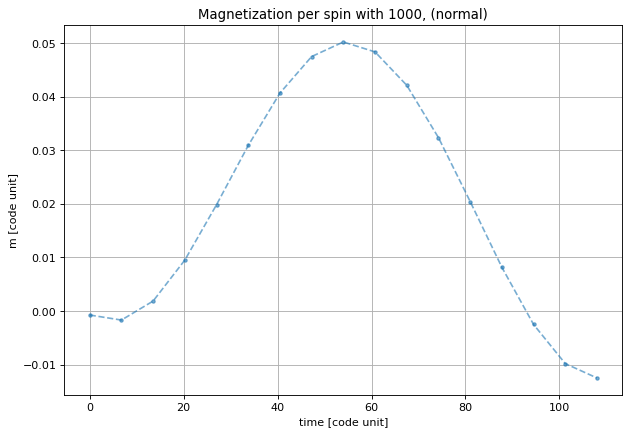

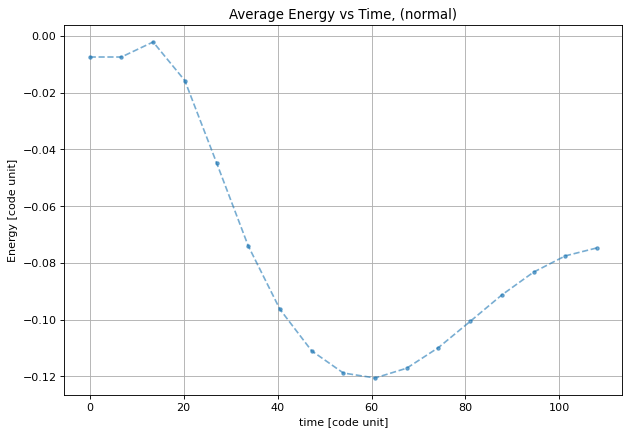

ValueError: x must be strictly increasing

In [303]:
'''
main for normal loop
'''
print("Norm \n")
t1 = time.time()
spin = grid_generator(width, length, init_rank = 3.0, dec = 2)[1] # include boundary
main(N, n, tmax, spin, J, sigma_x, sigma_y, eta)
t2 = time.time()

print(f"Taking {np.round((t2 - t1), 3)} [s]")
print("Finish!")

Eq 

Initial t = 0, succeed to output!
0, t = 7, succeed to output!
4, t = 35, succeed to output!
8, t = 63, succeed to output!
12, t = 91, succeed to output!
16, t = 119, succeed to output!
20, t = 147, succeed to output!
24, t = 175, succeed to output!
28, t = 203, succeed to output!
32, t = 231, succeed to output!
36, t = 259, succeed to output!
40, t = 287, succeed to output!
44, t = 315, succeed to output!
48, t = 343, succeed to output!
52, t = 371, succeed to output!
56, t = 399, succeed to output!
60, t = 427, succeed to output!
64, t = 455, succeed to output!
68, t = 483, succeed to output!
72, t = 511, succeed to output!
76, t = 539, succeed to output!
80, t = 567, succeed to output!
84, t = 595, succeed to output!
88, t = 623, succeed to output!
92, t = 651, succeed to output!
96, t = 679, succeed to output!
100, t = 707, succeed to output!
104, t = 735, succeed to output!
108, t = 763, succeed to output!
112, t = 791, succeed to output!
116, t = 819, succeed to output!
120,

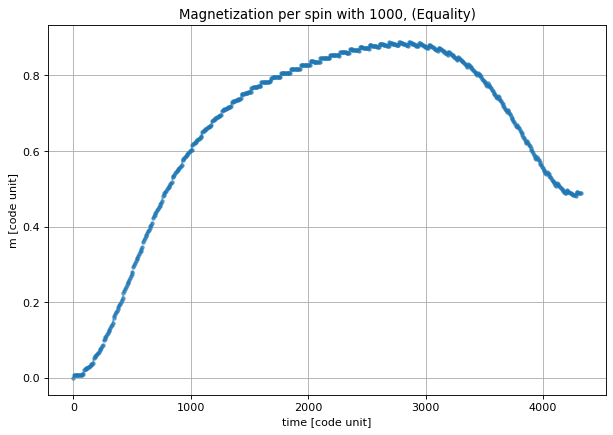

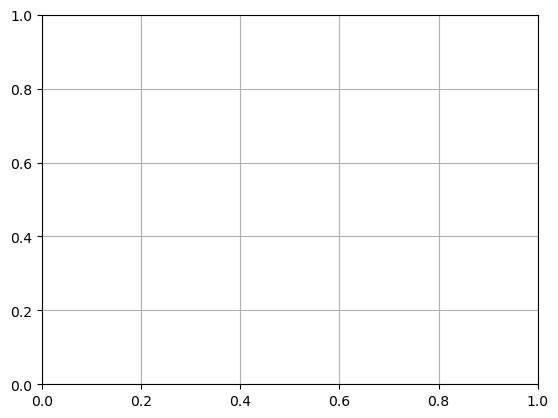

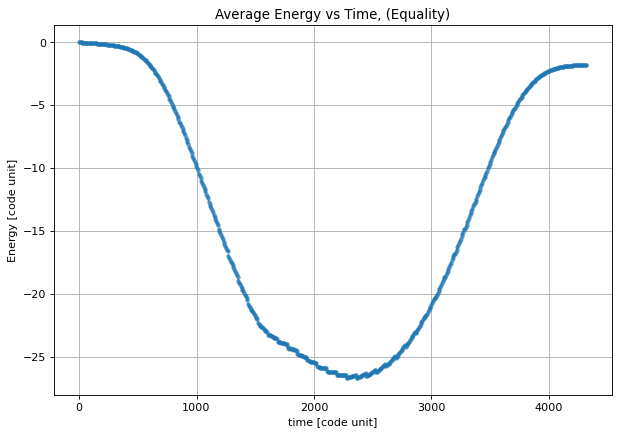

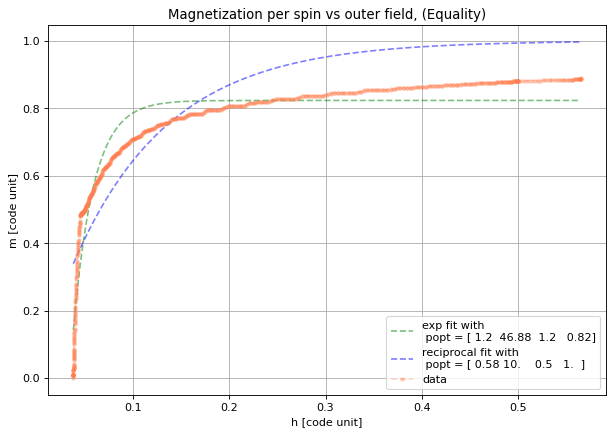

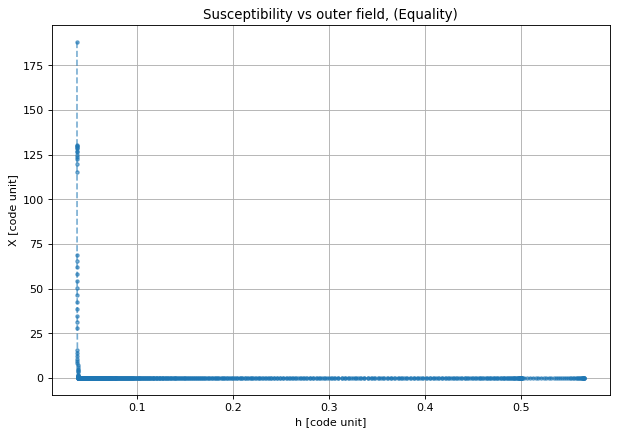

Done! Time =  78.865 [s]
Taking 79.819 [s]
Finish!


In [ ]:
'''
main loop of equality
'''
print("Eq \n")
t1 = time.time()
spin = grid_generator(width, length, init_rank = 3.0, dec = 2)[1] # include boundary
main_e(N, n, tmax, spin, J, sigma_x, sigma_y, eta, se, s_time)
t2 = time.time()

print(f"Taking {np.round((t2 - t1), 3)} [s]")
print("Finish!")

Ju 

Initial t = 0, succeed to output!
0, t = 7, succeed to output!
4, t = 35, succeed to output!
8, t = 63, succeed to output!
12, t = 91, succeed to output!
16, t = 119, succeed to output!
20, t = 147, succeed to output!
24, t = 175, succeed to output!
28, t = 203, succeed to output!
32, t = 231, succeed to output!
36, t = 259, succeed to output!
40, t = 287, succeed to output!
44, t = 315, succeed to output!
48, t = 343, succeed to output!
52, t = 371, succeed to output!
56, t = 399, succeed to output!
60, t = 427, succeed to output!
64, t = 455, succeed to output!
68, t = 483, succeed to output!
72, t = 511, succeed to output!
76, t = 539, succeed to output!
80, t = 567, succeed to output!
84, t = 595, succeed to output!
88, t = 623, succeed to output!
92, t = 651, succeed to output!
96, t = 679, succeed to output!
100, t = 707, succeed to output!
104, t = 735, succeed to output!
108, t = 763, succeed to output!
112, t = 791, succeed to output!
116, t = 819, succeed to output!
120,

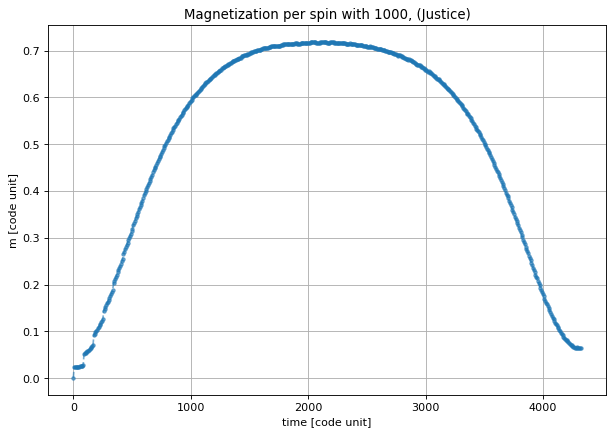

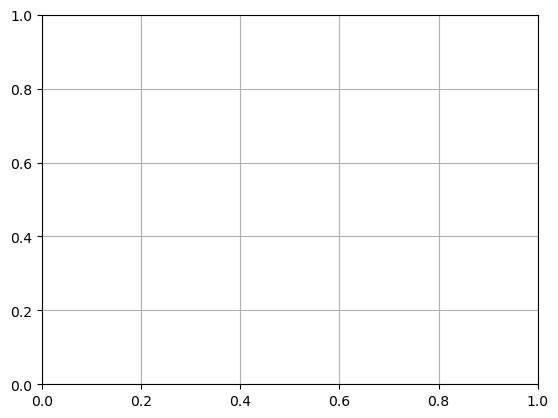

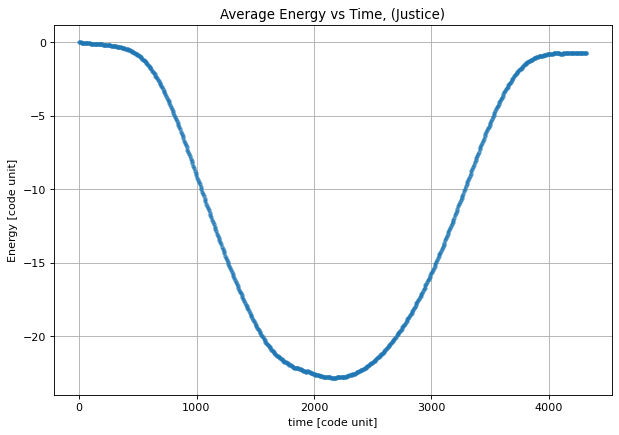

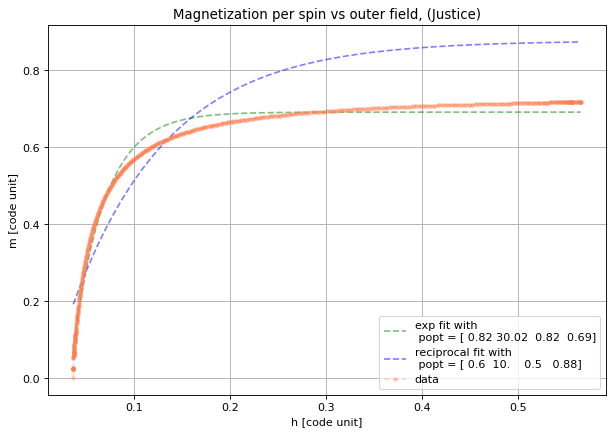

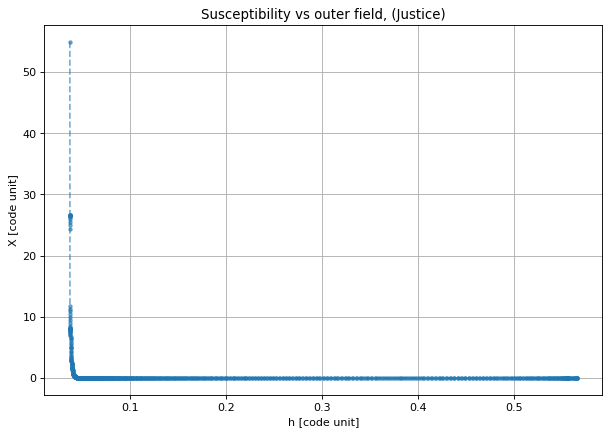

Done! Time =  79.792 [s]
Taking 80.826 [s]
Finish!


In [ ]:
'''
main loop of jutice
'''
print("Ju \n")
t1 = time.time()
spin = grid_generator(width, length, init_rank = 3.0, dec = 2)[1] # include boundary
main_j(N, n, tmax, spin, J, sigma_x, sigma_y, eta, se, s_time)
t2 = time.time()

print(f"Taking {np.round((t2 - t1), 3)} [s]")
print("Finish!")

### Creat GIF

In [ ]:
'''
eq spin
'''

# Create the frames
frames = []
imgs = glob.glob(f"{io_folder_fig}/fig_Common_Prosperity_eq_spin_*.png")
imgs.sort()
# check the sorted result
print(imgs)

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('eq_spin.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=200, loop=0)

print("Done!")

['fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_000.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_001.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_005.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_009.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_013.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_017.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_021.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_025.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_029.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_033.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_037.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_041.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_045.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_049.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_053.png', 'fig_Common_Prosperity/fig_Common_Prosperity_eq_spin_0

In [ ]:
'''
jutice spin
'''

# Create the frames
frames = []
imgs = glob.glob(f"{io_folder_fig}/fig_Common_Prosperity_ju_spin_*.png")
imgs.sort()
# check the sorted result
print(imgs)

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('ju_spin.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=200, loop=0)

print("Done!")

['fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_000.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_001.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_005.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_009.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_013.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_017.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_021.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_025.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_029.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_033.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_037.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_041.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_045.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_049.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_053.png', 'fig_Common_Prosperity/fig_Common_Prosperity_ju_spin_0

In [ ]:
'''
norm spin
'''

# Create the frames
frames = []
imgs = glob.glob(f"{io_folder_fig}/fig_Common_Prosperity_norm_spin_*.png")
imgs.sort()
# check the sorted result
print(imgs)

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('norm_spin.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=200, loop=0)

print("Done!")

['fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_000.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_001.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_005.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_009.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_013.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_017.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_021.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_025.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_029.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_033.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_037.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_041.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_045.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_049.png', 'fig_Common_Prosperity/fig_Common_Prosperity_norm_spin_053.png', 'fig_Common_Prosperity/f

In [ ]:
# '''
# Energy
# '''

# # Create the frames
# frames = []
# imgs = glob.glob(f"{io_folder_fig}/fig_Common_Prosperity_norm_energy_*.png")
# imgs.sort()
# # check the sorted result
# print(imgs)

# for i in imgs:
#     new_frame = Image.open(i)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save('energy.gif', format='GIF',
#                 append_images=frames[1:],
#                 save_all=True,
#                 duration=300, loop=0)

# print("Done!")